In [26]:
# ===== Libraries =====
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns



In [27]:
# ===== Load CSV =====
df = pd.read_csv("regimes.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df = df.dropna()


In [28]:
# ===== Feature Engineering =====
# Rolling momentum
df["momentum_5"] = df["return"].rolling(5).mean()
df["momentum_10"] = df["return"].rolling(10).mean()

# Lagged returns
df["return_lag1"] = df["return"].shift(1)
df["return_lag2"] = df["return"].shift(2)

# Rolling vol & drawdown
df["volatility_10"] = df["volatility"].rolling(10).mean()
df["drawdown_10"] = df["drawdown"].rolling(10).mean()

# New features
df["return_rolling_mean_20"] = df["return"].rolling(20).mean()
df["return_rolling_std_20"] = df["return"].rolling(20).std()
df["volatility_ratio"] = df["volatility"] / df["volatility_10"]
df["drawdown_change"] = df["drawdown"] - df["drawdown_10"]
df["regime_shift"] = (df["regime"] != df["regime"].shift(1)).astype(int)

# Strategy signal & returns
df["signal"] = (df["return"].rolling(20).mean() > 0).astype(int)
df["strategy_ret"] = df["signal"].shift(1) * df["return"]

# Failure = next-day large loss
threshold = df["return"].quantile(0.05)
df["failure"] = (df["return"].shift(-1) < threshold).astype(int)


In [29]:
# ===== Features & Target =====
feature_cols = [
    "volatility", "drawdown", "regime",
    "momentum_5", "momentum_10",
    "volatility_10", "drawdown_10",
    "return_lag1", "return_lag2",
    "return_rolling_mean_20", "return_rolling_std_20",
    "volatility_ratio", "drawdown_change", "regime_shift"
]

X = df[feature_cols]
y = df["failure"]

# ===== Clean NaN / Inf =====
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
y = y.loc[X.index]



In [30]:
# ===== Train-Test Split (no shuffling) =====
split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# ===== Scale =====
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
X_train_res, y_train_res = X_train_scaled, y_train

In [32]:
# ===== Models =====
# Logistic Regression
lr_model = LogisticRegression(class_weight="balanced", max_iter=1000)
lr_model.fit(X_train_res, y_train_res)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)
rf_model.fit(X_train_res, y_train_res)

# XGBoost (improved)
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.1,
    scale_pos_weight=(len(y_train)-y_train.sum())/y_train.sum(),
    eval_metric="logloss",
    random_state=42
)
xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
# ===== Evaluation =====
models = {"Logistic Regression": lr_model, "Random Forest": rf_model, "XGBoost": xgb_model}

for name, m in models.items():
    y_prob = m.predict_proba(X_test_scaled)[:, 1]
    y_pred = m.predict(X_test_scaled)
    print(f"\n{name}")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # Save predicted failure probability
    df.loc[X_test.index, f"failure_prob_{name}"] = y_prob


Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      1261
           1       0.11      0.50      0.18        48

    accuracy                           0.83      1309
   macro avg       0.54      0.67      0.54      1309
weighted avg       0.95      0.83      0.88      1309

ROC AUC: 0.713768834258525

Random Forest
              precision    recall  f1-score   support

           0       0.98      0.84      0.90      1261
           1       0.12      0.56      0.19        48

    accuracy                           0.83      1309
   macro avg       0.55      0.70      0.55      1309
weighted avg       0.95      0.83      0.88      1309

ROC AUC: 0.72011300555115

XGBoost
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1261
           1       0.11      0.25      0.16        48

    accuracy                           0.90      1309
   macro avg       0.54      0

In [34]:
# ===== Regime-Level Analysis =====
regime_risk = df.dropna(subset=[f"failure_prob_Logistic Regression"]).groupby("regime")[[f"failure_prob_{name}" for name in models]].mean()
regime_perf = df.dropna(subset=["strategy_ret"]).groupby("regime")["strategy_ret"].mean()

print("\nAverage Failure Probability per Regime:\n", regime_risk)
print("\nAverage Strategy Return per Regime:\n", regime_perf)


Average Failure Probability per Regime:
         failure_prob_Logistic Regression  failure_prob_Random Forest  \
regime                                                                 
0                               0.600137                    0.538223   
1                               0.307331                    0.196393   
2                               0.694429                    0.632466   

        failure_prob_XGBoost  
regime                        
0                   0.336612  
1                   0.088870  
2                   0.465473  

Average Strategy Return per Regime:
 regime
0   -0.001790
1    0.000711
2    0.005052
Name: strategy_ret, dtype: float64


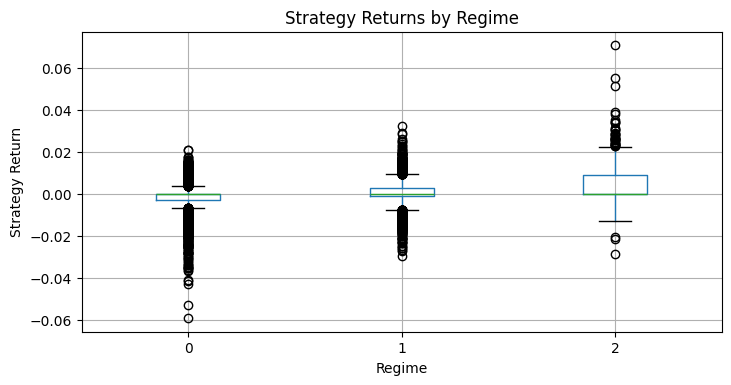

In [36]:
# ===== Save Outputs =====
output_cols = ["regime","volatility","drawdown","strategy_ret","failure"] + [f"failure_prob_{name}" for name in models]
output_df = df.dropna(subset=[f"failure_prob_Logistic Regression"])[output_cols]
output_df.to_csv("model2_outputs.csv")
output_df.reset_index().to_json("model2_outputs.json", orient="records")

# ===== Visualization =====
df.boxplot(column="strategy_ret", by="regime", figsize=(8,4))
plt.title("Strategy Returns by Regime")
plt.suptitle("")
plt.xlabel("Regime")
plt.ylabel("Strategy Return")
plt.show()